# Red Inicial


## Imports


In [1]:
from __future__ import annotations

from itertools import product
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from custom_env.actions import Acciones
from custom_env.router_env import RouterEnv
from gymnasium import make
from gymnasium.utils.env_checker import check_env
from pandas import DataFrame, Series
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor

Cargado a las 2025-03-12 22:25:27.782515


In [2]:
name = "Example"
tmp_path = "./train_log/"
env_id = "RouterEnv-v0"

progress_bar = True
if progress_bar == True:
    import rich
    import tqdm

## Clases y Funciones


In [3]:

"""

class PacketAttack(Enum):
    @staticmethod
    def new_set(description, weight, class_ref):
        return {
            "Description": description,
            "weight": weight,
            "class": class_ref
        }

    @staticmethod
    def not_implemented():
        raise NotImplementedError(f"Class not implemented")
    @classmethod
    @cache
    def weights(cls):
        attack_weights = []
        for attack in PacketAttack:
            attack_weights.append(attack.value["weight"])
        return np.array(attack_weights)

    # ----ENUM VALUES----
    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)
    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)


gen = DOS_Packet_Generator(step_dur=1e-6,seed=1)




print(len(gen.generate_packets()))

"""

'\n\nclass PacketAttack(Enum):\n    @staticmethod\n    def new_set(description, weight, class_ref):\n        return {\n            "Description": description,\n            "weight": weight,\n            "class": class_ref\n        }\n\n    @staticmethod\n    def not_implemented():\n        raise NotImplementedError(f"Class not implemented")\n    @classmethod\n    @cache\n    def weights(cls):\n        attack_weights = []\n        for attack in PacketAttack:\n            attack_weights.append(attack.value["weight"])\n        return np.array(attack_weights)\n\n    # ----ENUM VALUES----\n    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)\n    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)\n\n\ngen = DOS_Packet_Generator(step_dur=1e-6,seed=1)\n\n\n\n\nprint(len(gen.generate_packets()))\n\n'

In [4]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones


def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun

## Entrenamiento


In [5]:
seed = None
env: RouterEnv = make(env_id, seed=seed)
# env = RouterEnv(seed=None)
check_env(env)

new_logger: Logger = configure(tmp_path, ["stdout", "csv"])
env = Monitor(env, tmp_path)


model: PPO = PPO("MultiInputPolicy", env,
                 verbose=True)


"""
eval_callback = EvalCallback(
    env,  # Entorno de evaluación
    best_model_save_path="./logs/best_model",  # Ruta para guardar el mejor modelo
    log_path="./logs",  # Ruta para guardar estadísticas
    eval_freq=10000,  # Frecuencia de evaluación (en pasos)
    deterministic=True,
    render=False,
)
, callback=eval_callback
"""
"""
ep_info = a.ep_info_buffer
print(a.ep_info_buffer)
if ep_info is not None and len(ep_info) > 0:
    rew=ep_info[0]["r"]
    print(rew)
    saved= PPO.load("Example")
    print(ep_info.pop())
"""


model.set_logger(new_logger)
try:
    model.learn(total_timesteps=int(1e5//0.5),
                progress_bar=progress_bar)
except KeyboardInterrupt:
    print("Entrenamiento interrumpido")


g: str = input("¿Desea guardarlo? (s/n) ")
if g.lower() == "s":
    model.save(name)
    print("Modelo guardado")

Logging to ./train_log/


Using cpu device
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -407     |
| time/              |          |
|    fps             | 541      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -910        |
| time/                   |             |
|    fps                  | 463         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006722546 |
|    clip_fraction        | 0.0583      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.00204    |
|    learning_rate        | 0.0003      |
|    loss                 | 920         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000423   |
|    value_loss           | 3.08e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -822         |
| time/                   |              |
|    fps                  | 459          |
|    iterations           | 3            |
|    time_elapsed         | 13           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0013300276 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.689       |
|    explained_variance   | 0.0255       |
|    learning_rate        | 0.0003       |
|    loss                 | 5.17e+03     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00139     |
|    value_loss           | 2.25e+04     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -683          |
| time/                   |               |
|    fps                  | 446           |
|    iterations           | 4             |
|    time_elapsed         | 18            |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 0.00025754745 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.691        |
|    explained_variance   | 0.0477        |
|    learning_rate        | 0.0003        |
|    loss                 | 2.15e+03      |
|    n_updates            | 30            |
|    policy_gradient_loss | 2.23e-05      |
|    value_loss           | 5.84e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -595         |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 5            |
|    time_elapsed         | 23           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0031809113 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.688       |
|    explained_variance   | 0.106        |
|    learning_rate        | 0.0003       |
|    loss                 | 397          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0033      |
|    value_loss           | 1.18e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -514        |
| time/                   |             |
|    fps                  | 439         |
|    iterations           | 6           |
|    time_elapsed         | 27          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.004109828 |
|    clip_fraction        | 0.0184      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.69       |
|    explained_variance   | 0.136       |
|    learning_rate        | 0.0003      |
|    loss                 | 595         |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00683    |
|    value_loss           | 1.25e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -439        |
| time/                   |             |
|    fps                  | 439         |
|    iterations           | 7           |
|    time_elapsed         | 32          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.013922943 |
|    clip_fraction        | 0.0894      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | 0.263       |
|    learning_rate        | 0.0003      |
|    loss                 | 39.3        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 82          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | -491       |
| time/                   |            |
|    fps                  | 441        |
|    iterations           | 8          |
|    time_elapsed         | 37         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01106675 |
|    clip_fraction        | 0.098      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.644     |
|    explained_variance   | 0.293      |
|    learning_rate        | 0.0003     |
|    loss                 | 106        |
|    n_updates            | 70         |
|    policy_gradient_loss | -0.00597   |
|    value_loss           | 277        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -418         |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 9            |
|    time_elapsed         | 41           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0044040093 |
|    clip_fraction        | 0.0376       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.648       |
|    explained_variance   | 0.162        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.84e+03     |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00446     |
|    value_loss           | 5.6e+03      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -403        |
| time/                   |             |
|    fps                  | 446         |
|    iterations           | 10          |
|    time_elapsed         | 45          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.009843441 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.583      |
|    explained_variance   | 0.113       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.8        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 70.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -351        |
| time/                   |             |
|    fps                  | 450         |
|    iterations           | 11          |
|    time_elapsed         | 50          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.004128071 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.608      |
|    explained_variance   | 0.432       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.06e+03    |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00436    |
|    value_loss           | 1.03e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -325        |
| time/                   |             |
|    fps                  | 450         |
|    iterations           | 12          |
|    time_elapsed         | 54          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.009228384 |
|    clip_fraction        | 0.0493      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.525      |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.1        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00237    |
|    value_loss           | 81.4        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -355         |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 13           |
|    time_elapsed         | 58           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0030384497 |
|    clip_fraction        | 0.0084       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.521       |
|    explained_variance   | 0.537        |
|    learning_rate        | 0.0003       |
|    loss                 | 168          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.0021      |
|    value_loss           | 596          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -325          |
| time/                   |               |
|    fps                  | 452           |
|    iterations           | 14            |
|    time_elapsed         | 63            |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 0.00072795607 |
|    clip_fraction        | 0.00659       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.5          |
|    explained_variance   | 0.37          |
|    learning_rate        | 0.0003        |
|    loss                 | 6.01e+03      |
|    n_updates            | 130           |
|    policy_gradient_loss | -0.000175     |
|    value_loss           | 7.48e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -291         |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 15           |
|    time_elapsed         | 68           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0017530692 |
|    clip_fraction        | 0.00884      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.509       |
|    explained_variance   | 0.717        |
|    learning_rate        | 0.0003       |
|    loss                 | 177          |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.000333    |
|    value_loss           | 358          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -339        |
| time/                   |             |
|    fps                  | 451         |
|    iterations           | 16          |
|    time_elapsed         | 72          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.005522375 |
|    clip_fraction        | 0.0341      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.46       |
|    explained_variance   | 0.602       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.9        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00193    |
|    value_loss           | 91          |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -312         |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 17           |
|    time_elapsed         | 77           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0065429937 |
|    clip_fraction        | 0.0354       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.566       |
|    explained_variance   | 0.322        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.56e+03     |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00678     |
|    value_loss           | 1.13e+04     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -283         |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 18           |
|    time_elapsed         | 82           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0018009066 |
|    clip_fraction        | 0.0142       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.434       |
|    explained_variance   | 0.668        |
|    learning_rate        | 0.0003       |
|    loss                 | 57           |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.000493    |
|    value_loss           | 116          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -256        |
| time/                   |             |
|    fps                  | 446         |
|    iterations           | 19          |
|    time_elapsed         | 87          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.005079931 |
|    clip_fraction        | 0.0583      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.389      |
|    explained_variance   | 0.452       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.5        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00311    |
|    value_loss           | 76.7        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -277         |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 20           |
|    time_elapsed         | 92           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0005476247 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.43        |
|    explained_variance   | 0.458        |
|    learning_rate        | 0.0003       |
|    loss                 | 157          |
|    n_updates            | 190          |
|    policy_gradient_loss | 0.000551     |
|    value_loss           | 829          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -264         |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 21           |
|    time_elapsed         | 97           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0039363317 |
|    clip_fraction        | 0.00586      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.488       |
|    explained_variance   | 0.606        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.61e+03     |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00322     |
|    value_loss           | 4.29e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -178         |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 22           |
|    time_elapsed         | 101          |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0018440373 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.398       |
|    explained_variance   | 0.723        |
|    learning_rate        | 0.0003       |
|    loss                 | 29.3         |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.000371    |
|    value_loss           | 83.9         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -171         |
| time/                   |              |
|    fps                  | 443          |
|    iterations           | 23           |
|    time_elapsed         | 106          |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0037873315 |
|    clip_fraction        | 0.0132       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.383       |
|    explained_variance   | 0.552        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.2         |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.000415    |
|    value_loss           | 97.5         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -144         |
| time/                   |              |
|    fps                  | 443          |
|    iterations           | 24           |
|    time_elapsed         | 110          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0003996806 |
|    clip_fraction        | 0.00459      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.412       |
|    explained_variance   | 0.457        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.07e+03     |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00033     |
|    value_loss           | 6.36e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -160        |
| time/                   |             |
|    fps                  | 444         |
|    iterations           | 25          |
|    time_elapsed         | 115         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.004467901 |
|    clip_fraction        | 0.0215      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.471      |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.0003      |
|    loss                 | 298         |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00493    |
|    value_loss           | 409         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -195         |
| time/                   |              |
|    fps                  | 445          |
|    iterations           | 26           |
|    time_elapsed         | 119          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0005193621 |
|    clip_fraction        | 0.00894      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.472       |
|    explained_variance   | 0.543        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.47e+03     |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.000827    |
|    value_loss           | 4.26e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -142        |
| time/                   |             |
|    fps                  | 446         |
|    iterations           | 27          |
|    time_elapsed         | 123         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.002527567 |
|    clip_fraction        | 0.0268      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.469      |
|    explained_variance   | 0.674       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.3e+03     |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00705    |
|    value_loss           | 4.64e+03    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | -137       |
| time/                   |            |
|    fps                  | 447        |
|    iterations           | 28         |
|    time_elapsed         | 128        |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.00509564 |
|    clip_fraction        | 0.0395     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.384     |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.0003     |
|    loss                 | 112        |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.0029    |
|    value_loss           | 280        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -131        |
| time/                   |             |
|    fps                  | 447         |
|    iterations           | 29          |
|    time_elapsed         | 132         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.005040326 |
|    clip_fraction        | 0.0227      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.417      |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.0003      |
|    loss                 | 132         |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00166    |
|    value_loss           | 353         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | -130       |
| time/                   |            |
|    fps                  | 448        |
|    iterations           | 30         |
|    time_elapsed         | 137        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.00413396 |
|    clip_fraction        | 0.0231     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.0003     |
|    loss                 | 51.1       |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.00143   |
|    value_loss           | 148        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -117         |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 31           |
|    time_elapsed         | 141          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0047436934 |
|    clip_fraction        | 0.0198       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.394       |
|    explained_variance   | 0.811        |
|    learning_rate        | 0.0003       |
|    loss                 | 460          |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00217     |
|    value_loss           | 1.14e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -68.6       |
| time/                   |             |
|    fps                  | 449         |
|    iterations           | 32          |
|    time_elapsed         | 145         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.004773316 |
|    clip_fraction        | 0.0295      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.366      |
|    explained_variance   | 0.779       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.5        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00141    |
|    value_loss           | 208         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -88.7        |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 33           |
|    time_elapsed         | 150          |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0027039368 |
|    clip_fraction        | 0.047        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.358       |
|    explained_variance   | 0.748        |
|    learning_rate        | 0.0003       |
|    loss                 | 66.3         |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.00405     |
|    value_loss           | 143          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -76.9        |
| time/                   |              |
|    fps                  | 450          |
|    iterations           | 34           |
|    time_elapsed         | 154          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0032687848 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.417       |
|    explained_variance   | 0.868        |
|    learning_rate        | 0.0003       |
|    loss                 | 309          |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00266     |
|    value_loss           | 439          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -10.7        |
| time/                   |              |
|    fps                  | 450          |
|    iterations           | 35           |
|    time_elapsed         | 159          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0041438015 |
|    clip_fraction        | 0.052        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.243       |
|    explained_variance   | 0.552        |
|    learning_rate        | 0.0003       |
|    loss                 | 37.5         |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00286     |
|    value_loss           | 100          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -4.97        |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 36           |
|    time_elapsed         | 164          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0014401958 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.288       |
|    explained_variance   | 0.51         |
|    learning_rate        | 0.0003       |
|    loss                 | 70.2         |
|    n_updates            | 350          |
|    policy_gradient_loss | 0.000174     |
|    value_loss           | 105          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -4.27       |
| time/                   |             |
|    fps                  | 448         |
|    iterations           | 37          |
|    time_elapsed         | 169         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.002035133 |
|    clip_fraction        | 0.0188      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.377      |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.2        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.000434   |
|    value_loss           | 112         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -11.9        |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 38           |
|    time_elapsed         | 173          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0022876125 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.271       |
|    explained_variance   | 0.595        |
|    learning_rate        | 0.0003       |
|    loss                 | 55.3         |
|    n_updates            | 370          |
|    policy_gradient_loss | -7.1e-05     |
|    value_loss           | 92.7         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 20.9         |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 39           |
|    time_elapsed         | 178          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0032213547 |
|    clip_fraction        | 0.0205       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.353       |
|    explained_variance   | 0.791        |
|    learning_rate        | 0.0003       |
|    loss                 | 66.3         |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00189     |
|    value_loss           | 145          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 39.8         |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 40           |
|    time_elapsed         | 182          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0025702908 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.282       |
|    explained_variance   | 0.735        |
|    learning_rate        | 0.0003       |
|    loss                 | 102          |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 148          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 37.2         |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 41           |
|    time_elapsed         | 187          |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0012670197 |
|    clip_fraction        | 0.0103       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.265       |
|    explained_variance   | 0.747        |
|    learning_rate        | 0.0003       |
|    loss                 | 69.2         |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.000249    |
|    value_loss           | 165          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 79.4        |
| time/                   |             |
|    fps                  | 448         |
|    iterations           | 42          |
|    time_elapsed         | 191         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.002688656 |
|    clip_fraction        | 0.0395      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.303      |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | 76.8        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00282    |
|    value_loss           | 167         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 76.4         |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 43           |
|    time_elapsed         | 196          |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0032645063 |
|    clip_fraction        | 0.0271       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.211       |
|    explained_variance   | 0.626        |
|    learning_rate        | 0.0003       |
|    loss                 | 43.9         |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00128     |
|    value_loss           | 106          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 83.1         |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 44           |
|    time_elapsed         | 200          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0018092662 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.26        |
|    explained_variance   | 0.669        |
|    learning_rate        | 0.0003       |
|    loss                 | 89.9         |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00182     |
|    value_loss           | 185          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 450         |
|    iterations           | 45          |
|    time_elapsed         | 204         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.000807692 |
|    clip_fraction        | 0.0112      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.154      |
|    explained_variance   | 0.683       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.1        |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.000723    |
|    value_loss           | 96.3        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 165          |
| time/                   |              |
|    fps                  | 450          |
|    iterations           | 46           |
|    time_elapsed         | 209          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0009611235 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 0.663        |
|    learning_rate        | 0.0003       |
|    loss                 | 55.8         |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.000144    |
|    value_loss           | 105          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 166          |
| time/                   |              |
|    fps                  | 450          |
|    iterations           | 47           |
|    time_elapsed         | 213          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0048665972 |
|    clip_fraction        | 0.0303       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.2         |
|    explained_variance   | 0.673        |
|    learning_rate        | 0.0003       |
|    loss                 | 72.8         |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.0022      |
|    value_loss           | 141          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 170          |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 48           |
|    time_elapsed         | 218          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0012501162 |
|    clip_fraction        | 0.0193       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.143       |
|    explained_variance   | 0.546        |
|    learning_rate        | 0.0003       |
|    loss                 | 65           |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.000593    |
|    value_loss           | 109          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 163          |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 49           |
|    time_elapsed         | 223          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0044112448 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.235       |
|    explained_variance   | 0.778        |
|    learning_rate        | 0.0003       |
|    loss                 | 86.1         |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00265     |
|    value_loss           | 147          |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 400       |
|    ep_rew_mean          | 187       |
| time/                   |           |
|    fps                  | 449       |
|    iterations           | 50        |
|    time_elapsed         | 227       |
|    total_timesteps      | 102400    |
| train/                  |           |
|    approx_kl            | 0.0025271 |
|    clip_fraction        | 0.00713   |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.17     |
|    explained_variance   | 0.778     |
|    learning_rate        | 0.0003    |
|    loss                 | 41.4      |
|    n_updates            | 490       |
|    policy_gradient_loss | 0.000408  |
|    value_loss           | 102       |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 184          |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 51           |
|    time_elapsed         | 232          |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0015696607 |
|    clip_fraction        | 0.00981      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.138       |
|    explained_variance   | 0.537        |
|    learning_rate        | 0.0003       |
|    loss                 | 49.1         |
|    n_updates            | 500          |
|    policy_gradient_loss | 0.000524     |
|    value_loss           | 124          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 188         |
| time/                   |             |
|    fps                  | 449         |
|    iterations           | 52          |
|    time_elapsed         | 236         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.002023222 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.168      |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | 99.9        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.00217    |
|    value_loss           | 155         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 207          |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 53           |
|    time_elapsed         | 241          |
|    total_timesteps      | 108544       |
| train/                  |              |
|    approx_kl            | 0.0012877178 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.146       |
|    explained_variance   | 0.774        |
|    learning_rate        | 0.0003       |
|    loss                 | 54.9         |
|    n_updates            | 520          |
|    policy_gradient_loss | -0.00158     |
|    value_loss           | 124          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 197           |
| time/                   |               |
|    fps                  | 447           |
|    iterations           | 54            |
|    time_elapsed         | 246           |
|    total_timesteps      | 110592        |
| train/                  |               |
|    approx_kl            | 0.00082475715 |
|    clip_fraction        | 0.0142        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.13         |
|    explained_variance   | 0.434         |
|    learning_rate        | 0.0003        |
|    loss                 | 65            |
|    n_updates            | 530           |
|    policy_gradient_loss | 0.00186       |
|    value_loss           | 116           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 194          |
| time/                   |              |
|    fps                  | 447          |
|    iterations           | 55           |
|    time_elapsed         | 251          |
|    total_timesteps      | 112640       |
| train/                  |              |
|    approx_kl            | 0.0069718976 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.186       |
|    explained_variance   | 0.614        |
|    learning_rate        | 0.0003       |
|    loss                 | 77.8         |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.000652    |
|    value_loss           | 186          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 198          |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 56           |
|    time_elapsed         | 255          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0007191015 |
|    clip_fraction        | 0.00449      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.222       |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.0003       |
|    loss                 | 77.3         |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.00037     |
|    value_loss           | 182          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 198          |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 57           |
|    time_elapsed         | 260          |
|    total_timesteps      | 116736       |
| train/                  |              |
|    approx_kl            | 0.0034097172 |
|    clip_fraction        | 0.0164       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.0003       |
|    loss                 | 115          |
|    n_updates            | 560          |
|    policy_gradient_loss | -0.00186     |
|    value_loss           | 192          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 203         |
| time/                   |             |
|    fps                  | 449         |
|    iterations           | 58          |
|    time_elapsed         | 264         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.003414796 |
|    clip_fraction        | 0.0136      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 0.663       |
|    learning_rate        | 0.0003      |
|    loss                 | 95.2        |
|    n_updates            | 570         |
|    policy_gradient_loss | -0.000217   |
|    value_loss           | 170         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 200          |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 59           |
|    time_elapsed         | 268          |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 0.0011937006 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.141       |
|    explained_variance   | 0.512        |
|    learning_rate        | 0.0003       |
|    loss                 | 64.5         |
|    n_updates            | 580          |
|    policy_gradient_loss | 0.00104      |
|    value_loss           | 128          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 197         |
| time/                   |             |
|    fps                  | 450         |
|    iterations           | 60          |
|    time_elapsed         | 272         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.002840499 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.684       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.3        |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.000368   |
|    value_loss           | 190         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 200          |
| time/                   |              |
|    fps                  | 450          |
|    iterations           | 61           |
|    time_elapsed         | 277          |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0027036848 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 0.817        |
|    learning_rate        | 0.0003       |
|    loss                 | 94.5         |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00132     |
|    value_loss           | 173          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 195         |
| time/                   |             |
|    fps                  | 451         |
|    iterations           | 62          |
|    time_elapsed         | 281         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.000500162 |
|    clip_fraction        | 0.00786     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0946     |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.0003      |
|    loss                 | 42          |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.000195    |
|    value_loss           | 124         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 193          |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 63           |
|    time_elapsed         | 285          |
|    total_timesteps      | 129024       |
| train/                  |              |
|    approx_kl            | 0.0017420405 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.0003       |
|    loss                 | 60.6         |
|    n_updates            | 620          |
|    policy_gradient_loss | 0.00123      |
|    value_loss           | 163          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 191           |
| time/                   |               |
|    fps                  | 451           |
|    iterations           | 64            |
|    time_elapsed         | 290           |
|    total_timesteps      | 131072        |
| train/                  |               |
|    approx_kl            | 0.00071003987 |
|    clip_fraction        | 0.00527       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.136        |
|    explained_variance   | 0.805         |
|    learning_rate        | 0.0003        |
|    loss                 | 63.3          |
|    n_updates            | 630           |
|    policy_gradient_loss | -0.000187     |
|    value_loss           | 163           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 195          |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 65           |
|    time_elapsed         | 294          |
|    total_timesteps      | 133120       |
| train/                  |              |
|    approx_kl            | 0.0022062124 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.121       |
|    explained_variance   | 0.671        |
|    learning_rate        | 0.0003       |
|    loss                 | 123          |
|    n_updates            | 640          |
|    policy_gradient_loss | 3.02e-05     |
|    value_loss           | 121          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 196          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 66           |
|    time_elapsed         | 298          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0012492149 |
|    clip_fraction        | 0.0083       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0851      |
|    explained_variance   | 0.562        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.3         |
|    n_updates            | 650          |
|    policy_gradient_loss | 5.51e-05     |
|    value_loss           | 106          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 187          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 67           |
|    time_elapsed         | 303          |
|    total_timesteps      | 137216       |
| train/                  |              |
|    approx_kl            | 0.0022765244 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0712      |
|    explained_variance   | 0.568        |
|    learning_rate        | 0.0003       |
|    loss                 | 47.6         |
|    n_updates            | 660          |
|    policy_gradient_loss | -0.00105     |
|    value_loss           | 113          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 185          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 68           |
|    time_elapsed         | 308          |
|    total_timesteps      | 139264       |
| train/                  |              |
|    approx_kl            | 0.0021867775 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.147       |
|    explained_variance   | 0.751        |
|    learning_rate        | 0.0003       |
|    loss                 | 75.1         |
|    n_updates            | 670          |
|    policy_gradient_loss | -0.00124     |
|    value_loss           | 181          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 189          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 69           |
|    time_elapsed         | 312          |
|    total_timesteps      | 141312       |
| train/                  |              |
|    approx_kl            | 0.0024551095 |
|    clip_fraction        | 0.022        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.146       |
|    explained_variance   | 0.815        |
|    learning_rate        | 0.0003       |
|    loss                 | 77.5         |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.000649    |
|    value_loss           | 178          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 186           |
| time/                   |               |
|    fps                  | 452           |
|    iterations           | 70            |
|    time_elapsed         | 316           |
|    total_timesteps      | 143360        |
| train/                  |               |
|    approx_kl            | 0.00021843739 |
|    clip_fraction        | 0.0129        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0698       |
|    explained_variance   | 0.317         |
|    learning_rate        | 0.0003        |
|    loss                 | 43.9          |
|    n_updates            | 690           |
|    policy_gradient_loss | 0.000941      |
|    value_loss           | 111           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 180          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 71           |
|    time_elapsed         | 321          |
|    total_timesteps      | 145408       |
| train/                  |              |
|    approx_kl            | 0.0012853718 |
|    clip_fraction        | 0.0143       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.117       |
|    explained_variance   | 0.688        |
|    learning_rate        | 0.0003       |
|    loss                 | 53.6         |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.000271    |
|    value_loss           | 149          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 175          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 72           |
|    time_elapsed         | 325          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0011529559 |
|    clip_fraction        | 0.0166       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.174       |
|    explained_variance   | 0.789        |
|    learning_rate        | 0.0003       |
|    loss                 | 151          |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.000776    |
|    value_loss           | 271          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 166          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 73           |
|    time_elapsed         | 330          |
|    total_timesteps      | 149504       |
| train/                  |              |
|    approx_kl            | 0.0009836559 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.104       |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.0003       |
|    loss                 | 124          |
|    n_updates            | 720          |
|    policy_gradient_loss | 0.000278     |
|    value_loss           | 183          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 159          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 74           |
|    time_elapsed         | 335          |
|    total_timesteps      | 151552       |
| train/                  |              |
|    approx_kl            | 0.0011352722 |
|    clip_fraction        | 0.00942      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.0003       |
|    loss                 | 83.5         |
|    n_updates            | 730          |
|    policy_gradient_loss | 0.000633     |
|    value_loss           | 261          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 162          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 75           |
|    time_elapsed         | 339          |
|    total_timesteps      | 153600       |
| train/                  |              |
|    approx_kl            | 0.0009551973 |
|    clip_fraction        | 0.0111       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.167       |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.0003       |
|    loss                 | 76.9         |
|    n_updates            | 740          |
|    policy_gradient_loss | 0.000284     |
|    value_loss           | 204          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 168          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 76           |
|    time_elapsed         | 344          |
|    total_timesteps      | 155648       |
| train/                  |              |
|    approx_kl            | 0.0020427613 |
|    clip_fraction        | 0.0166       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.114       |
|    explained_variance   | 0.742        |
|    learning_rate        | 0.0003       |
|    loss                 | 76.1         |
|    n_updates            | 750          |
|    policy_gradient_loss | -0.000805    |
|    value_loss           | 192          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 163           |
| time/                   |               |
|    fps                  | 451           |
|    iterations           | 77            |
|    time_elapsed         | 348           |
|    total_timesteps      | 157696        |
| train/                  |               |
|    approx_kl            | 0.00051782647 |
|    clip_fraction        | 0.0125        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0734       |
|    explained_variance   | 0.535         |
|    learning_rate        | 0.0003        |
|    loss                 | 56.5          |
|    n_updates            | 760           |
|    policy_gradient_loss | 0.000159      |
|    value_loss           | 118           |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 165         |
| time/                   |             |
|    fps                  | 451         |
|    iterations           | 78          |
|    time_elapsed         | 353         |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.009196308 |
|    clip_fraction        | 0.0249      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.148      |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | 80.1        |
|    n_updates            | 770         |
|    policy_gradient_loss | 1.43e-05    |
|    value_loss           | 160         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 186          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 79           |
|    time_elapsed         | 357          |
|    total_timesteps      | 161792       |
| train/                  |              |
|    approx_kl            | 0.0005728783 |
|    clip_fraction        | 0.0177       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0901      |
|    explained_variance   | 0.597        |
|    learning_rate        | 0.0003       |
|    loss                 | 58.6         |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.000329    |
|    value_loss           | 118          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 181           |
| time/                   |               |
|    fps                  | 451           |
|    iterations           | 80            |
|    time_elapsed         | 362           |
|    total_timesteps      | 163840        |
| train/                  |               |
|    approx_kl            | 0.00055513345 |
|    clip_fraction        | 0.0149        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0838       |
|    explained_variance   | 0.631         |
|    learning_rate        | 0.0003        |
|    loss                 | 83.6          |
|    n_updates            | 790           |
|    policy_gradient_loss | -0.00047      |
|    value_loss           | 104           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 178          |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 81           |
|    time_elapsed         | 367          |
|    total_timesteps      | 165888       |
| train/                  |              |
|    approx_kl            | 0.0010545643 |
|    clip_fraction        | 0.0183       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.171       |
|    explained_variance   | 0.74         |
|    learning_rate        | 0.0003       |
|    loss                 | 34.6         |
|    n_updates            | 800          |
|    policy_gradient_loss | 0.0018       |
|    value_loss           | 131          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 172          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 82           |
|    time_elapsed         | 371          |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0011819126 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 0.622        |
|    learning_rate        | 0.0003       |
|    loss                 | 97.9         |
|    n_updates            | 810          |
|    policy_gradient_loss | 0.000332     |
|    value_loss           | 171          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 170        |
| time/                   |            |
|    fps                  | 452        |
|    iterations           | 83         |
|    time_elapsed         | 376        |
|    total_timesteps      | 169984     |
| train/                  |            |
|    approx_kl            | 0.01047066 |
|    clip_fraction        | 0.0378     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.167     |
|    explained_variance   | 0.651      |
|    learning_rate        | 0.0003     |
|    loss                 | 74.4       |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.00224   |
|    value_loss           | 186        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 169         |
| time/                   |             |
|    fps                  | 451         |
|    iterations           | 84          |
|    time_elapsed         | 380         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.001076672 |
|    clip_fraction        | 0.0242      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 0.684       |
|    learning_rate        | 0.0003      |
|    loss                 | 71.1        |
|    n_updates            | 830         |
|    policy_gradient_loss | 0.000458    |
|    value_loss           | 194         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 165          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 85           |
|    time_elapsed         | 384          |
|    total_timesteps      | 174080       |
| train/                  |              |
|    approx_kl            | 0.0011661663 |
|    clip_fraction        | 0.00747      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.111       |
|    explained_variance   | 0.576        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.9         |
|    n_updates            | 840          |
|    policy_gradient_loss | 0.000882     |
|    value_loss           | 134          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 161          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 86           |
|    time_elapsed         | 389          |
|    total_timesteps      | 176128       |
| train/                  |              |
|    approx_kl            | 0.0009569896 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.12        |
|    explained_variance   | 0.657        |
|    learning_rate        | 0.0003       |
|    loss                 | 89.2         |
|    n_updates            | 850          |
|    policy_gradient_loss | 0.000367     |
|    value_loss           | 166          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 185          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 87           |
|    time_elapsed         | 393          |
|    total_timesteps      | 178176       |
| train/                  |              |
|    approx_kl            | 0.0006514732 |
|    clip_fraction        | 0.00991      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0943      |
|    explained_variance   | 0.67         |
|    learning_rate        | 0.0003       |
|    loss                 | 62.3         |
|    n_updates            | 860          |
|    policy_gradient_loss | 0.000167     |
|    value_loss           | 156          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 180           |
| time/                   |               |
|    fps                  | 452           |
|    iterations           | 88            |
|    time_elapsed         | 398           |
|    total_timesteps      | 180224        |
| train/                  |               |
|    approx_kl            | 0.00047352893 |
|    clip_fraction        | 0.00771       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.113        |
|    explained_variance   | 0.699         |
|    learning_rate        | 0.0003        |
|    loss                 | 87.8          |
|    n_updates            | 870           |
|    policy_gradient_loss | 3.94e-05      |
|    value_loss           | 149           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 171          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 89           |
|    time_elapsed         | 402          |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 0.0011559885 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.13        |
|    explained_variance   | 0.756        |
|    learning_rate        | 0.0003       |
|    loss                 | 78.2         |
|    n_updates            | 880          |
|    policy_gradient_loss | -0.000452    |
|    value_loss           | 172          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 175           |
| time/                   |               |
|    fps                  | 452           |
|    iterations           | 90            |
|    time_elapsed         | 407           |
|    total_timesteps      | 184320        |
| train/                  |               |
|    approx_kl            | 0.00082066224 |
|    clip_fraction        | 0.00327       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.112        |
|    explained_variance   | 0.778         |
|    learning_rate        | 0.0003        |
|    loss                 | 62.4          |
|    n_updates            | 890           |
|    policy_gradient_loss | 9.46e-05      |
|    value_loss           | 143           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 188          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 91           |
|    time_elapsed         | 411          |
|    total_timesteps      | 186368       |
| train/                  |              |
|    approx_kl            | 0.0035930942 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.104       |
|    explained_variance   | 0.549        |
|    learning_rate        | 0.0003       |
|    loss                 | 123          |
|    n_updates            | 900          |
|    policy_gradient_loss | 0.000499     |
|    value_loss           | 180          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 196          |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 92           |
|    time_elapsed         | 416          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0011434751 |
|    clip_fraction        | 0.00923      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0799      |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.0003       |
|    loss                 | 83.2         |
|    n_updates            | 910          |
|    policy_gradient_loss | 0.000545     |
|    value_loss           | 109          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 201          |
| time/                   |              |
|    fps                  | 453          |
|    iterations           | 94           |
|    time_elapsed         | 424          |
|    total_timesteps      | 192512       |
| train/                  |              |
|    approx_kl            | 0.0015754974 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.102       |
|    explained_variance   | 0.726        |
|    learning_rate        | 0.0003       |
|    loss                 | 126          |
|    n_updates            | 930          |
|    policy_gradient_loss | 0.000124     |
|    value_loss           | 191          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 198          |
| time/                   |              |
|    fps                  | 453          |
|    iterations           | 95           |
|    time_elapsed         | 429          |
|    total_timesteps      | 194560       |
| train/                  |              |
|    approx_kl            | 0.0014394333 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.163       |
|    explained_variance   | 0.784        |
|    learning_rate        | 0.0003       |
|    loss                 | 94           |
|    n_updates            | 940          |
|    policy_gradient_loss | 0.00079      |
|    value_loss           | 223          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 199          |
| time/                   |              |
|    fps                  | 453          |
|    iterations           | 96           |
|    time_elapsed         | 433          |
|    total_timesteps      | 196608       |
| train/                  |              |
|    approx_kl            | 0.0003869762 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.11        |
|    explained_variance   | 0.667        |
|    learning_rate        | 0.0003       |
|    loss                 | 95.1         |
|    n_updates            | 950          |
|    policy_gradient_loss | 0.00029      |
|    value_loss           | 194          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 195          |
| time/                   |              |
|    fps                  | 453          |
|    iterations           | 97           |
|    time_elapsed         | 437          |
|    total_timesteps      | 198656       |
| train/                  |              |
|    approx_kl            | 0.0023366287 |
|    clip_fraction        | 0.0278       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.105       |
|    explained_variance   | 0.607        |
|    learning_rate        | 0.0003       |
|    loss                 | 79.5         |
|    n_updates            | 960          |
|    policy_gradient_loss | 0.00128      |
|    value_loss           | 126          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 188        |
| time/                   |            |
|    fps                  | 453        |
|    iterations           | 98         |
|    time_elapsed         | 442        |
|    total_timesteps      | 200704     |
| train/                  |            |
|    approx_kl            | 0.02582017 |
|    clip_fraction        | 0.0522     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.128     |
|    explained_variance   | 0.674      |
|    learning_rate        | 0.0003     |
|    loss                 | 70.8       |
|    n_updates            | 970        |
|    policy_gradient_loss | 0.00111    |
|    value_loss           | 165        |
----------------------------------------


Modelo guardado


### Gráficas de Entrenamiento


['time/iterations', 'rollout/ep_rew_mean', 'time/fps', 'time/time_elapsed', 'time/total_timesteps', 'rollout/ep_len_mean', 'train/n_updates', 'train/clip_fraction', 'train/loss', 'train/explained_variance', 'train/value_loss', 'train/approx_kl', 'train/entropy_loss', 'train/clip_range', 'train/learning_rate', 'train/policy_gradient_loss']


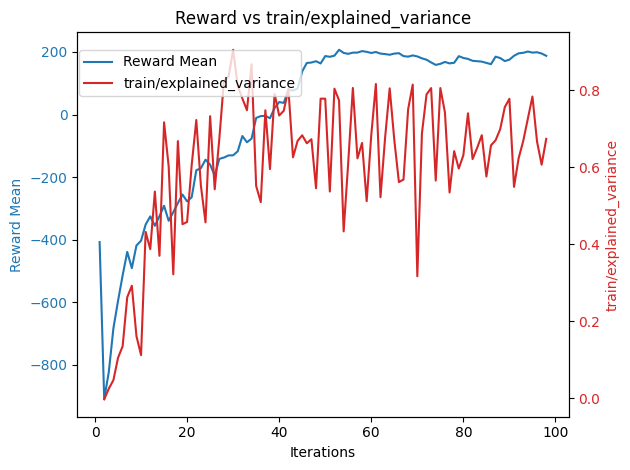

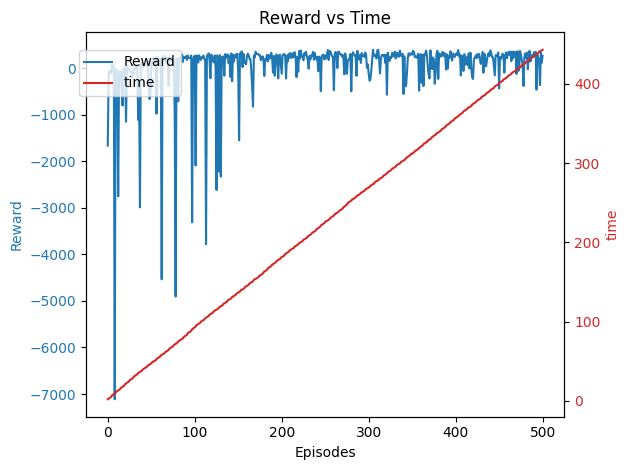

In [6]:
train_data_log: DataFrame = pd.read_csv(tmp_path+"progress.csv")
train_data_monitor: DataFrame = pd.read_csv(tmp_path+"monitor.csv", header=1)

# train_data_monitor = pd.concat([train_data_monitor] * 3, ignore_index=True)
print(train_data_log.columns.to_list())

fig, ax1 = plt.subplots()

iterations: Series[int] = train_data_log['time/iterations'].astype(int)


ax1.set_xlabel('Iterations')
color = 'tab:blue'
ax1.set_ylabel('Reward Mean', color=color)
ax1.plot(iterations,
         train_data_log['rollout/ep_rew_mean'], color=color, label='Reward Mean')
ax1.tick_params(axis='y', labelcolor=color)


col = 'train/explained_variance'

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(col, color=color)
ax2.plot(iterations, train_data_log[col], color=color, label=col)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Reward vs ' + col)


fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()


fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, train_data_monitor['r'], color=color, label='Reward')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Reward vs Time')


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('time', color=color)
ax2.plot(episodes, train_data_monitor['t'], color=color, label='time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

## Comprobación funcionamiento


In [5]:
seed = 289980628190634006122751570777790489191
env = make(env_id, seed=seed)
seed: int=env.np_random_seed
model = PPO.load(name, print_system_info=True)
print(type(env))
num_steps = 1
obs, _ = env.reset(seed=seed)
# Variables de información:
acciones = []
rewards = []
ocu = []
tams = []
num = []
lim_ocu = 0
a2 = []
estados=[]

# -------------------------

_states = None
ant = env._get_info()
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)
        if len(ant) > 0 and ant != info:
            print(info["Stats"])
        ant = info

        ocu.append(info["Stats"]["OcupacionActual"])
        tams.append(info["Stats"]["TamañoTotal"])
        num.append(info["Stats"]["NumPaquetes"])
        a2.append(info["Stats"]["Action"])
        estados.append(info["Stats"]["EstadoMaquina"])

        rewards.append(reward)
        acciones.append(action.item())

        done: bool = done or terminated

    env.reset(seed=seed)
    step_counter += 1
#estados = env.registro_Estados()
# Debug
print(f"Acciones: {acciones}")
print(list(map(lambda x: Acciones.int_to_action(x), acciones)))
print(list(map(lambda x: int(round(x, 0)), rewards)))
print(a2)
print(acciones.count(acciones[-1])/len(acciones))
print(f"Seed: {env.np_random_seed}")

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

<class 'custom_env.router_env.RouterEnv'>
{'EstadoMaquina': 'AttackState', 'NumPaquetes': 0, 'TamañoTotal': 0.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.0, 'Descartados': 0}
{'EstadoMaquina': 'AttackState', 'NumPaquetes': 5, 'TamañoTotal': 537.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.02, 'Descartados': 0}
{'EstadoMaquina': 'AttackState', 'NumPaquetes': 10, 'TamañoTotal': 1096.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.04, 'Descartados': 0}
{'EstadoMaquina': 'AttackState', 'NumPaquetes': 14, 'TamañoTotal': 1309.0, 'Actio

In [6]:
assert len(acciones) != a2.count(
    Acciones.DENEGAR), "Se han denegado todos los paquetes"
assert len(acciones) != a2.count(
    Acciones.PERMITIR), "Se han permitido todos los paquetes"

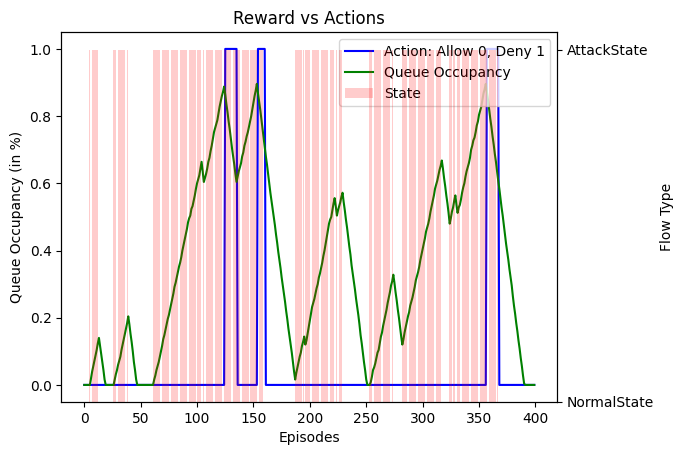

Rewards:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.75, -2.75, -2.5, -2.5, -2.75, -2.75, -2.75, -2.75, -2.75, -2.5, -2.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.75, -2.5, -2.75, -2.5, -2.75, -2.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [7]:
assert len(acciones) == len(rewards)
# plt.plot(rewards, label="rewards")

fig, ax1 = plt.subplots()

# Primer eje Y con acciones y ocupación de cola
ax1.plot(acciones, label=f"Action: Allow {Acciones.action_to_int(Acciones.PERMITIR)}, Deny {Acciones.action_to_int(Acciones.DENEGAR)}",color='#0000FF')
ax1.plot(ocu, label="Queue Occupancy",color='green')
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Queue Occupancy (in %)")
ax1.set_title("Reward vs Actions")

# Segundo eje Y con estados en gráfico de barras
ax2 = ax1.twinx()
ax2.bar(range(len(estados)), estados, color='red', label="State", alpha=0.20)
ax2.set_ylabel("Flow Type")

# Combinar leyendas de ambos ejes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.show()


print("Rewards: ", rewards)
num_permitidos: int = acciones.count(Acciones.action_to_int(Acciones.PERMITIR))
print(num_permitidos, len(acciones)-num_permitidos, "",
      num_permitidos/len(acciones), 1-num_permitidos/len(acciones))

Ocupación:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.04, 0.056, 0.072, 0.088, 0.104, 0.124, 0.14, 0.116, 0.092, 0.068, 0.044, 0.016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.032, 0.044, 0.06, 0.072, 0.084, 0.104, 0.12, 0.136, 0.152, 0.168, 0.184, 0.204, 0.18, 0.152, 0.128, 0.1, 0.068, 0.044, 0.016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.028, 0.044, 0.056, 0.068, 0.084, 0.1, 0.116, 0.136, 0.148, 0.164, 0.18, 0.196, 0.208, 0.224, 0.24, 0.256, 0.272, 0.292, 0.304, 0.32, 0.336, 0.352, 0.364, 0.38, 0.4, 0.416, 0.432, 0.448, 0.464, 0.484, 0.496, 0.504, 0.524, 0.532, 0.548, 0.564, 0.584, 0.6, 0.612, 0.624, 0.644, 0.664, 0.636, 0.604, 0.616, 0.628, 0.644, 0.664, 0.676, 0.696, 0.712, 0.732, 0.752, 0.764, 0.776, 0.788, 0.808, 0.828, 0.844, 0.86, 0.872, 0.888, 0.864, 0.836, 0.812, 0.784, 0.76, 0.732, 0.704, 0.68, 0.656, 0.628, 0.604, 0.62, 0.636, 0.648, 0.66, 0.68, 0.692, 0.712, 0.724, 0.74, 0.752, 0.768, 0.784, 0.8, 0.82, 0.84, 0.86, 0.876, 0.89

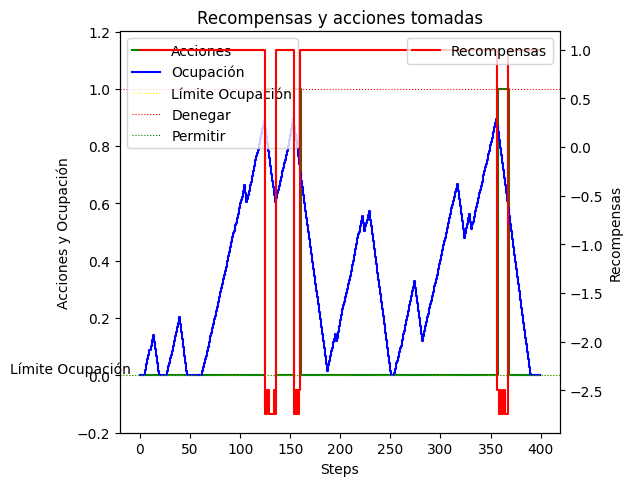

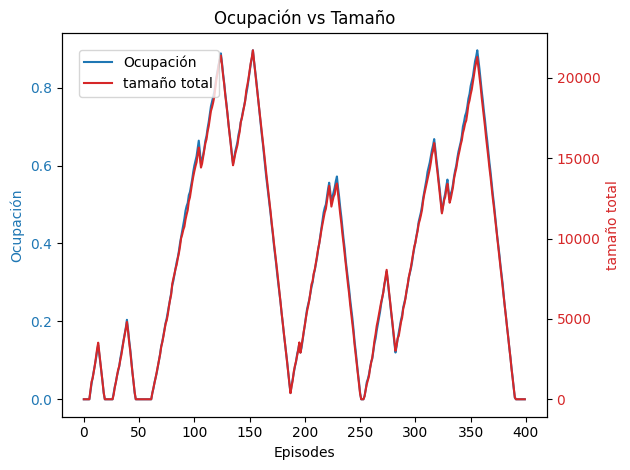

La ocupación máxima es de 90%
La ocupación mínima es de 0%


In [9]:
print("Ocupación: ", ocu)
fig, ax1 = plt.subplots()

# Configurar el eje X e Y
ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

# Graficar las acciones y la ocupación
ax1.step(range(len(acciones)), acciones, label="Acciones", where='post',color='green')
# ax1.step(range(len(acciones)), [1] * len(acciones), label="Denegar", where='mid')  # Ajustar según tus datos
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid', color='blue')

# Crear línea horizontal en el gráfico
ax1.axhline(y=lim_ocu, color='yellow', linestyle='dotted',
            linewidth=0.8, label='Límite Ocupación')

# Agregar marca en el eje Y
ticks = list(ax1.get_yticks())  # Obtener los ticks actuales
if lim_ocu not in ticks:
    ticks.append(lim_ocu)  # Agregar el límite de ocupación a los ticks
ax1.set_yticks(sorted(ticks))  # Actualizar los ticks

# Anotar el límite en el eje
ax1.annotate(
    'Límite Ocupación',
    xy=(-0.1, lim_ocu),  # Coordenada en el eje Y
    xytext=(-50, lim_ocu + 5),
    textcoords='offset points',
    fontsize=10, color='black',
    ha='center',
    va='center'
)
ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red',
            linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR),
            color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


# Leyenda del primer eje
ax1.legend(loc='upper left')

# Crear segundo eje Y para las recompensas
ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards,
         label="Recompensas", where='mid', color='r')

# Leyenda del segundo eje
ax2.legend(loc='upper right')

# Ajustar diseño y mostrar título
fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam = [x/1 for x in tams]


"""
plt.step(range(len(acciones)), acciones, label="acciones", where='mid')
plt.step(range(len(acciones)), [Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar", where='mid')
plt.plot([lim_ocu]*len(ocu), label="LimiteOcupación")
"""

fig, ax1 = plt.subplots()

train_data_monitor: DataFrame = pd.read_csv(tmp_path+"monitor.csv", header=1)

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
label = 'Ocupación'
ax1.set_ylabel(label, color=color)
ax1.plot(range(len(ocu)), ocu, color=color, label=label)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Ocupación vs Tamaño')


ax2 = ax1.twinx()
color = 'tab:red'
label = 'tamaño total'
ax2.set_ylabel(label, color=color)
ax2.plot(range(len(tams)), tam, color=color, label=label)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

"""plt.step(range(len(ocu)),ocu, label="Ocupación",where='mid')
plt.step(range(len(tams)),tam, label="Tamaño",where='mid')


plt.title("Recompensas y acciones tomadas")
plt.legend()
plt.show()"""
print(f"La ocupación máxima es de {np.max(ocu):.0%}")
print(f"La ocupación mínima es de {np.min(ocu):.0%}")

## Pruebas:


In [10]:
print(f"Tiempo medio: {tiempo_global/iteraciones if abs(iteraciones) > 1e-5 else 0:.2f} micro-segundos de {iteraciones} iteraciones")

Tiempo medio: 0.00 micro-segundos de 0 iteraciones


In [11]:
print(Acciones.action_to_int(Acciones.PERMITIR))
print(Acciones.action_to_int(Acciones.DENEGAR))

0
1


['NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'AttackState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalState', 'NormalSt

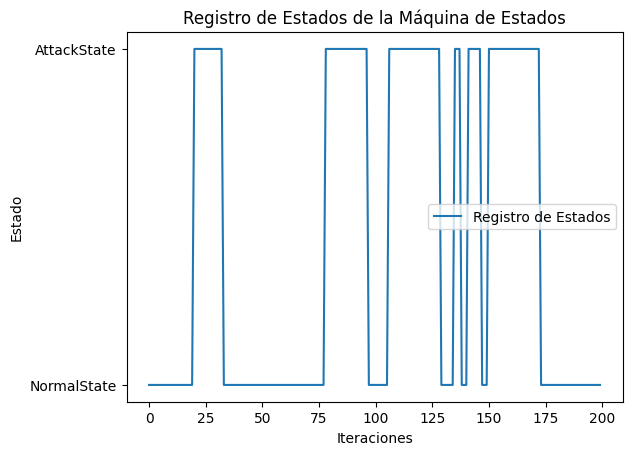

In [12]:
from custom_env.states import *
maquina = MaquinaDeEstados()
for _ in range(200):
    maquina.cambiar_estado()
print(maquina.registro_estados)

plt.plot(maquina.registro_estados, label="Registro de Estados")
plt.xlabel("Iteraciones")
plt.ylabel("Estado")
plt.title("Registro de Estados de la Máquina de Estados")
plt.legend()
plt.show()

In [13]:
# Lista de ejemplo
lista: list[str] = [x.__name__ for x in maquina.estados_posibles]
combinaciones_con_repeticion = list(product(lista, repeat=2))
dict_con: dict[tuple[str, str], int] = {
    x: 0 for x in combinaciones_con_repeticion}

print(dict_con)
duracion_ataques = []
estado_Ant = maquina.registro_estados[0]

for estado in maquina.registro_estados[1:]:
    dict_con[(estado_Ant, estado)] += 1

    if (estado_Ant, estado) == (NormalState.__name__, AttackState.__name__):  # Empieza ataque
        duracion_ataques.append(1)
    elif (estado_Ant, estado) == (AttackState.__name__, AttackState.__name__):  # Sigue ataque
        if len(duracion_ataques) > 0:
            duracion_ataques[-1] += 1

    estado_Ant: Estado = estado

print(
    f"Como promedio los {len(duracion_ataques)} ataques duran {np.mean(duracion_ataques):.1f} iteraciones.")
print("Duracion 5 primeros ataques: ", duracion_ataques[:5], "...")
try:
    for estado1 in lista:
        total = 0
        for estado2 in lista:
            total += dict_con[(estado1, estado2)]
        print(f"Estando en {estado1}:")
        for estado2 in lista:
            print(f"De {estado1} a {estado2}: {
                dict_con[(estado1, estado2)] / total:6.2%}")
except:
    pass

{('NormalState', 'NormalState'): 0, ('NormalState', 'AttackState'): 0, ('AttackState', 'NormalState'): 0, ('AttackState', 'AttackState'): 0}
Como promedio los 6 ataques duran 14.5 iteraciones.
Duracion 5 primeros ataques:  [13, 19, 23, 3, 6] ...
Estando en NormalState:
De NormalState a NormalState: 94.64%
De NormalState a AttackState:  5.36%
Estando en AttackState:
De AttackState a NormalState:  6.90%
De AttackState a AttackState: 93.10%


In [14]:
_np_random, _ = seeding.np_random(None)
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=True))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=False))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
print(type(0.0), type(0))
print(int(0.2))

1,10,5,3
1,9,5,3
<class 'float'> <class 'int'>
0
